## Business Scenario
A New York City-based real estate consultancy wants to improve its pricing strategy by more accurately estimating the market value of residential properties. Mispricing can lead to prolonged listings, missed revenue, and poor client experience.

As a data scientist at a consulting firm, the goal is to build a predictive model that estimates a property's sale price based on its physical attributes and location. This model will help real estate agents, investors, and property owners set more competitive and informed listing prices across the five boroughs of NYC.

## Business Objectives
The business objective would be to help a real estate firm in New York City accurately estimate housing prices based on property features and location. This would help agents set competitive listing prices which would 1) reduce time on the market and 2) maximize the seller's ROI.

Success will be measured technically by RMSE, MAE, and R-squared.

Business success will be being having a model be able to make predictions within 10% of the actual sales price for at least 80% of the created test set.

## Dataset Overview
The dataset I have selected is from Kaggle(https://www.kaggle.com/datasets/new-york-city/nyc-property-sales/data). It includes 84,548 rows and 22 columns before cleaning. 

The dataset includes all sales from a 12 month period (September 2016-2017) in New York City.

The dataset itself directly addresses the core question: what drives property prices in NYC? It includes variables that directly influence pricing decisions such as size, age, location, building type, etc. It also reflects actual sales transactions. All of this together provides a strong foundation for a supervised machine learning model.

CAVEAT: While the dataset reflects sales from 2016–2017, our objective is not to forecast current market prices but to understand the relationship between property characteristics and value. These relationships are relatively stable over time and remain highly informative for real estate strategy. With access to more recent data, this model could be retrained for production use.

## Why Machine Learning

Real estate pricing is influenced by complex, nonlinear relationships between location, property attributes, and market various dynamics. A machine learning model is ideal for this problem because:

It can capture complex patterns and interactions among dozens of features

It scales easily across thousands of property records

It supports continuous improvement as more data becomes available

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# pip install geopy


In [4]:
df = pd.read_csv('nyc-rolling-sales.csv')

## EDA

In [5]:
df.head(20)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
5,9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,,C4,516 EAST 12TH STREET,...,20,0,20,2581,9730,1900,2,C4,-,2017-07-20 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00
7,11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,,C7,520 EAST 14TH STREET,...,44,2,46,5163,21007,1900,2,C7,-,2017-07-20 00:00:00
8,12,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,,D5,141 AVENUE D,...,15,0,15,1534,9198,1920,2,D5,-,2017-06-20 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00


Borough: in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

Building class: https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html

Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement. (pulled directly from Kaggle)

In [6]:
df.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [7]:
df.info()

#will have to drop Unnamed: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [8]:
df.shape

(84548, 22)

In [9]:
df['EASE-MENT'].unique()
#will need to drop as no data

array([' '], dtype=object)

In [10]:
df['BUILDING CLASS CATEGORY'].unique()


#see link above

array(['07 RENTALS - WALKUP APARTMENTS             ',
       '08 RENTALS - ELEVATOR APARTMENTS           ',
       '09 COOPS - WALKUP APARTMENTS               ',
       '10 COOPS - ELEVATOR APARTMENTS             ',
       '11A CONDO-RENTALS                           ',
       '12 CONDOS - WALKUP APARTMENTS              ',
       '13 CONDOS - ELEVATOR APARTMENTS            ',
       '14 RENTALS - 4-10 UNIT                     ',
       '15 CONDOS - 2-10 UNIT RESIDENTIAL          ',
       '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT ',
       '17 CONDO COOPS                             ',
       '22 STORE BUILDINGS                         ',
       '37 RELIGIOUS FACILITIES                    ',
       '42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC  ',
       '46 CONDO STORE BUILDINGS                   ',
       '47 CONDO NON-BUSINESS STORAGE              ',
       '01 ONE FAMILY DWELLINGS                    ',
       '02 TWO FAMILY DWELLINGS                    ',
       '03 THREE FAMILY DWE

In [11]:
df.isnull().sum()

Unnamed: 0                        0
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
APARTMENT NUMBER                  0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [12]:
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
#change to numeric

In [13]:
df['SALE PRICE'].describe()

count    6.998700e+04
mean     1.276456e+06
std      1.140526e+07
min      0.000000e+00
25%      2.250000e+05
50%      5.300000e+05
75%      9.500000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

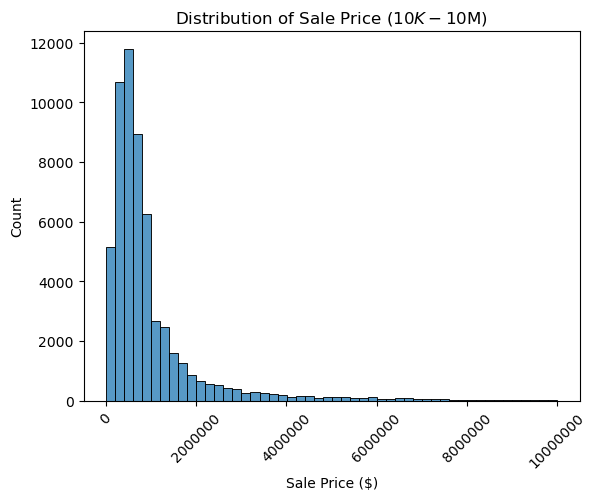

In [14]:
filtered = df[(df['SALE PRICE'] > 10_000) & (df['SALE PRICE'] < 10_000_000)]

sns.histplot(filtered['SALE PRICE'], bins=50)
plt.title('Distribution of Sale Price ($10K-$10M)')
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')  # Prevent scientific notation
plt.show()

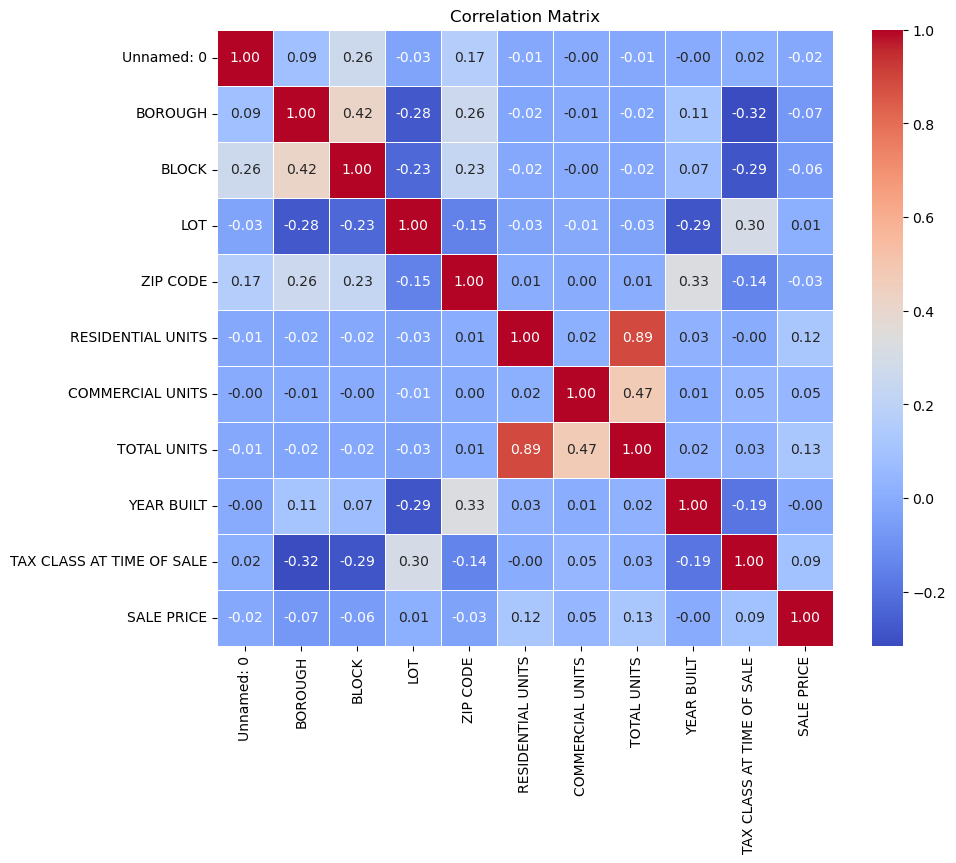

In [15]:
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Data Cleaning and Preprocssing

In [16]:
#drop column unnamed, EASEMENT, drop columns wehre sales price = 0

# Drop unnecessary columns
df.drop(columns=['Unnamed: 0','EASE-MENT'], errors='ignore', inplace=True)

# Drop rows where SALE PRICE is 0 or missing
df = df[df['SALE PRICE'] > 0]

In [17]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [ ]:
#feature engineering (part 1)
df['BUILDING_AGE'] = 2017 - df['YEAR BUILT']

df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['PRICE_PER_SQFT'] = df['SALE PRICE'] / df['GROSS SQUARE FEET'] #THIS SCREWS UP THE MODEL because it essentailly gives the answer

df = df[df['GROSS SQUARE FEET'] > 0]

In [19]:
df['FULL_ADDRESS'] = df['ADDRESS'].astype(str) + ', ' + df['BOROUGH'].astype(str) + ', NY ' + df['ZIP CODE'].astype(str)

In [20]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,...,1633,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00,117,1028.726708,"153 AVENUE B, 1, NY 10009"
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,...,2272,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00,104,579.374742,"154 EAST 7TH STREET, 1, NY 10009"
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,...,2369,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00,117,1733.477790,"301 EAST 10TH STREET, 1, NY 10009"
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,...,1750,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00,97,755.522953,"210 AVENUE B, 1, NY 10009"
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,...,4489,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00,97,876.315932,"629 EAST 5TH STREET, 1, NY 10009"


In [ ]:
from geopy.geocoders import Nominatim
import requests
import time

# Initialize geolocator
geolocator = Nominatim(user_agent="nyc_walkscore")

# Use your actual API key
api_key = '082ad7e1968c1cbba8f67068fe3f5d42'

# Step 1: Get lat/lon per ZIP
zip_latlon = {}
unique_zips = df['ZIP CODE'].dropna().unique()

for zip_code in unique_zips:
    try:
        location = geolocator.geocode(f"{zip_code}, NY")
        if location:
            zip_latlon[zip_code] = (location.latitude, location.longitude)
        else:
            zip_latlon[zip_code] = (None, None)
        time.sleep(1)
    except:
        zip_latlon[zip_code] = (None, None)

# Step 2: Fetch Walk Scores
zip_walkscore = {}

for zip_code, (lat, lon) in zip_latlon.items():
    if lat is None or lon is None:
        zip_walkscore[zip_code] = None
        continue

    url = "https://api.walkscore.com/score"
    params = {
        'format': 'json',
        'lat': lat,
        'lon': lon,
        'address': f"{zip_code}, NY",
        'wsapikey': api_key
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        score = data.get('walkscore', None)
        zip_walkscore[zip_code] = score
        time.sleep(1)
    except:
        zip_walkscore[zip_code] = None

# Step 3: Map scores back to the main DataFrame
df['WALK_SCORE_ZIP'] = df['ZIP CODE'].map(zip_walkscore)


In [22]:
df.to_csv("nyc_housing_block_lot.csv", index=False)

In [23]:
df=pd.read_csv('nyc_housing_block_lot.csv')

Worked with chat gpt get walkscore api working. lets see if we can get model improvement!

In [24]:
df[['ZIP CODE', 'WALK_SCORE_ZIP']].dropna().head(20)

,ZIP CODE,WALK_SCORE_ZIP
0,10009,100
1,10009,100
2,10009,100
3,10009,100
4,10009,100
5,10009,100
6,10009,100
7,10009,100
8,10009,100
9,10009,100


In [ ]:
df['WALK_SCORE_ZIP'].describe()
#confirms varience... not just 100 across teh board


count    29334.000000
mean        83.126815
std         15.337184
min         28.000000
25%         80.000000
50%         87.000000
75%         92.000000
max        100.000000
Name: WALK_SCORE_ZIP, dtype: float64

In [27]:
df = df[(df['COMMERCIAL UNITS'] == 0) & (df['RESIDENTIAL UNITS'] > 0)]
#want to look at residential. commercial/mixed use has different pricing such as rental income that we do not have here. This also removes empty lots


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26549 entries, 0 to 29331
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         26549 non-null  int64  
 1   NEIGHBORHOOD                    26549 non-null  object 
 2   BUILDING CLASS CATEGORY         26549 non-null  object 
 3   TAX CLASS AT PRESENT            26549 non-null  object 
 4   BLOCK                           26549 non-null  int64  
 5   LOT                             26549 non-null  int64  
 6   BUILDING CLASS AT PRESENT       26549 non-null  object 
 7   ADDRESS                         26549 non-null  object 
 8   APARTMENT NUMBER                26549 non-null  object 
 9   ZIP CODE                        26549 non-null  int64  
 10  RESIDENTIAL UNITS               26549 non-null  int64  
 11  COMMERCIAL UNITS                26549 non-null  int64  
 12  TOTAL UNITS                     26549

In [ ]:
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce') #convert... errors coerce for values that cannot be converted

In [31]:
df.drop(columns=['COMMERCIAL UNITS'], inplace=True) #just focusing on residential

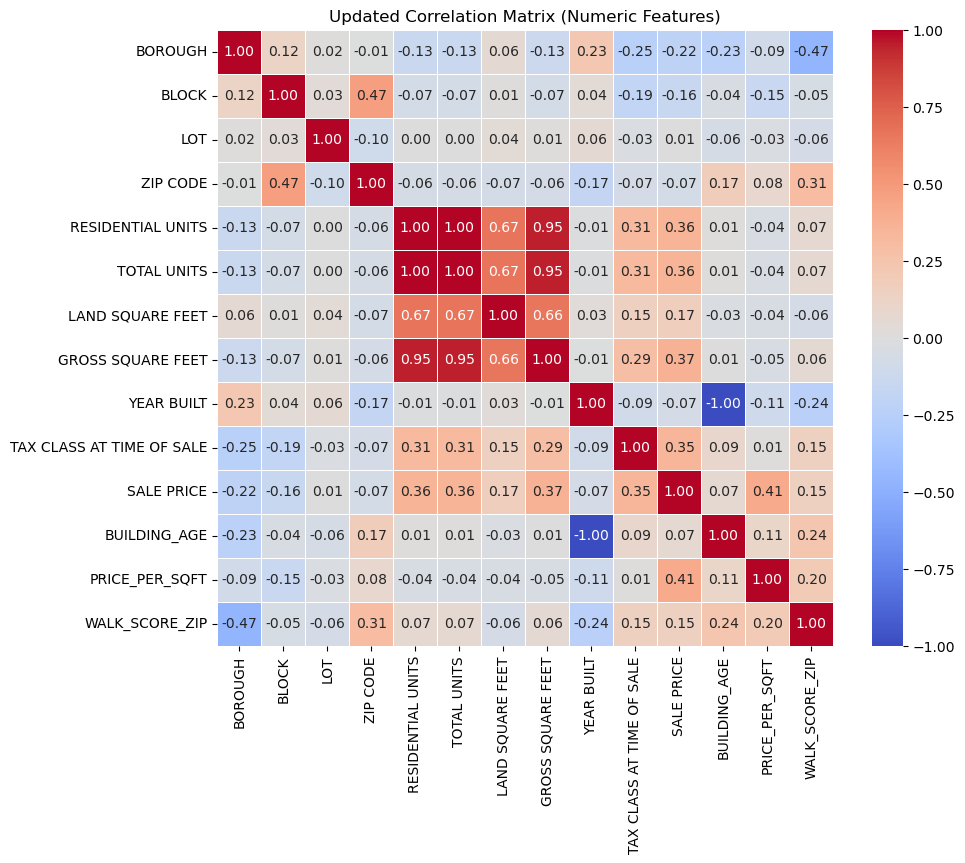

In [ ]:
numeric_df = df.select_dtypes(include='number')

#Compute correlation matrix
corr = numeric_df.corr()

#Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)
plt.title('Updated Correlation Matrix (Numeric Features)')
plt.show()

In [33]:
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE                   1.000000
PRICE_PER_SQFT               0.408792
GROSS SQUARE FEET            0.369633
RESIDENTIAL UNITS            0.358202
TOTAL UNITS                  0.358202
TAX CLASS AT TIME OF SALE    0.351205
LAND SQUARE FEET             0.170685
WALK_SCORE_ZIP               0.152068
BUILDING_AGE                 0.068274
LOT                          0.007734
YEAR BUILT                  -0.068274
ZIP CODE                    -0.072481
BLOCK                       -0.155657
BOROUGH                     -0.215083
Name: SALE PRICE, dtype: float64

In [34]:
#ask chatgpt for code to clean outliers in SALE PRICE, GROSS SQUARE FEET, LAND SQUARE FEET, PRICE PER SQFT

def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df = remove_outliers_iqr(df, 'SALE PRICE')
df = remove_outliers_iqr(df, 'GROSS SQUARE FEET')
df = remove_outliers_iqr(df, 'LAND SQUARE FEET')
df = remove_outliers_iqr(df, 'PRICE_PER_SQFT')


In [ ]:
df['BOROUGH'] = df['BOROUGH'].replace({
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'})

Changed numeric number to name of borough. Later in notebook need to reverse map to merge Pluto file.

In [37]:
df.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS,WALK_SCORE_ZIP
193,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,3524.0,1900,2,C2,313000.0,2017-05-23 00:00:00,117,88.819523,"38 BARROW STREET, 1, NY 10014",100
216,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,3200.0,1910,1,A9,1510000.0,2017-01-03 00:00:00,107,471.875000,"307 WEST 136 STREET, 1, NY 10030",97
223,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,3360.0,1899,1,A4,1000000.0,2016-09-29 00:00:00,118,297.619048,"227 EDGECOMBE AVENUE, 1, NY 10030",97
227,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,3240.0,1899,1,B1,1550000.0,2017-03-30 00:00:00,118,478.395062,"2040 MADISON AVENUE, 1, NY 10035",99
232,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,3600.0,1899,1,B1,1310000.0,2016-11-16 00:00:00,118,363.888889,"252 WEST 132 STREET, 1, NY 10027",99
234,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1941,59,B3,264 WEST 136 STREET,,10030,...,2625.0,1910,1,B3,850000.0,2017-03-27 00:00:00,107,323.809524,"264 WEST 136 STREET, 1, NY 10030",97
239,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,2041,28,B9,320 WEST 138 STREET,,10030,...,3400.0,1901,1,B9,1550000.0,2016-09-22 00:00:00,116,455.882353,"320 WEST 138 STREET, 1, NY 10030",97
250,Manhattan,HARLEM-CENTRAL,03 THREE FAMILY DWELLINGS,1,1911,4,C0,173 WEST 126 STREET,,10027,...,2596.0,1910,1,C0,60000.0,2017-06-16 00:00:00,107,23.112481,"173 WEST 126 STREET, 1, NY 10027",99
257,Manhattan,HARLEM-CENTRAL,07 RENTALS - WALKUP APARTMENTS,2A,1718,119,C3,49 WEST 119 STREET,,10026,...,2700.0,1909,2,C3,1320000.0,2017-02-28 00:00:00,108,488.888889,"49 WEST 119 STREET, 1, NY 10026",98
258,Manhattan,HARLEM-CENTRAL,07 RENTALS - WALKUP APARTMENTS,2A,1718,119,C3,49 WEST 119 STREET,,10026,...,2700.0,1909,2,C3,180000.0,2017-02-28 00:00:00,108,66.666667,"49 WEST 119 STREET, 1, NY 10026",98


In [39]:
df = df[df['SALE PRICE'] >= 10_000] #filtering out most family sales/deed transfers... did not use right variable as above

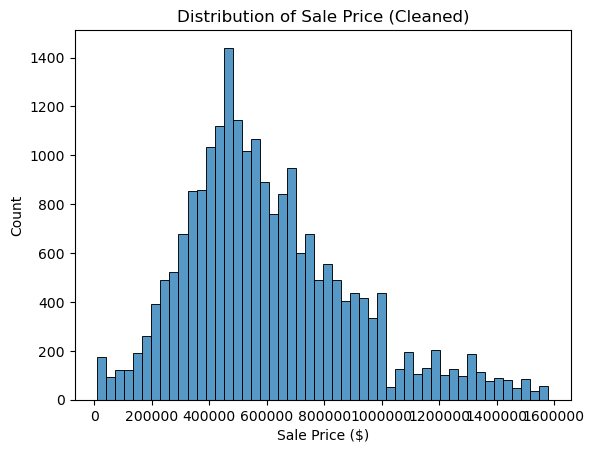

In [40]:
#show cleaned visualization
sns.histplot(df['SALE PRICE'], bins=50)
plt.title('Distribution of Sale Price (Cleaned)')
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [41]:
df.shape

(21758, 23)

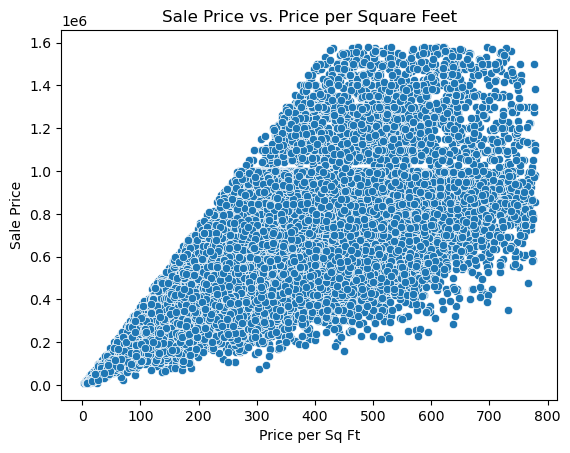

In [42]:
sns.scatterplot(data=df, x='PRICE_PER_SQFT', y='SALE PRICE')
plt.title('Sale Price vs. Price per Square Feet')
plt.xlabel('Price per Sq Ft')
plt.ylabel('Sale Price')
plt.show()

Unsurprising sale price goes up with price per square foot.

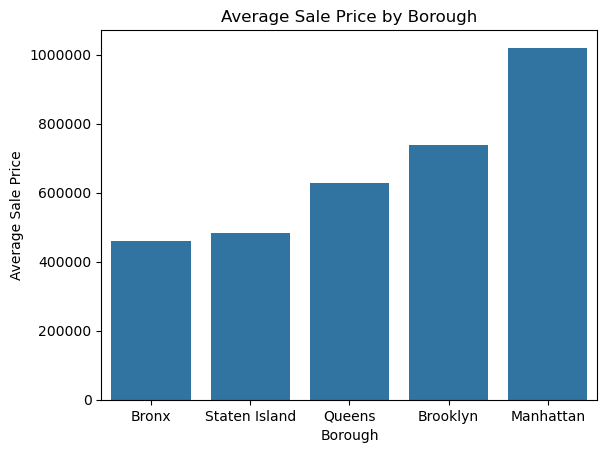

In [43]:
avg_price_by_borough = df.groupby('BOROUGH')['SALE PRICE'].mean().sort_values()

sns.barplot(x=avg_price_by_borough.index, y=avg_price_by_borough.values)
plt.title('Average Sale Price by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


Graph demonstrates that most expensive borough is Manhattan. Is it possible this is because it is the ideal location?

In [44]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
TOTAL UNITS                         int64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
SALE DATE                          object
BUILDING_AGE                        int64
PRICE_PER_SQFT                    float64
FULL_ADDRESS                       object
WALK_SCORE_ZIP                      int64
dtype: object

In [45]:
# df.to_csv('cleaned_nyc_sales_with_walkscore.csv', index=False)


In [46]:
df_income = pd.read_csv('NYC_Household_Median_Income.csv')

Try to get an idea of household median income. Maybe the more affluent areas are going to have higher prices. Another datapoint for the model to use.

In [47]:
df_income.head()

,zip,income_household_median
0,10001,123393
1,10002,46525
2,10003,153750
3,10004,220592
4,10005,211810


In [48]:
df_income.dtypes

zip                        int64
income_household_median    int64
dtype: object

In [49]:
df_income.isnull().sum()

zip                        0
income_household_median    0
dtype: int64

In [ ]:
df_income.rename(columns={'zip': 'ZIP CODE', 'income_household_median': 'ZIP_MEDIAN_INCOME'}, inplace=True)

In [51]:
df = df.merge(df_income[['ZIP CODE', 'ZIP_MEDIAN_INCOME']], on='ZIP CODE', how='left')

In [52]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,1900,2,C2,313000.0,2017-05-23 00:00:00,117,88.819523,"38 BARROW STREET, 1, NY 10014",100,167254.0
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,1910,1,A9,1510000.0,2017-01-03 00:00:00,107,471.875000,"307 WEST 136 STREET, 1, NY 10030",97,42738.0
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,1899,1,A4,1000000.0,2016-09-29 00:00:00,118,297.619048,"227 EDGECOMBE AVENUE, 1, NY 10030",97,42738.0
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,1899,1,B1,1550000.0,2017-03-30 00:00:00,118,478.395062,"2040 MADISON AVENUE, 1, NY 10035",99,40556.0
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,1899,1,B1,1310000.0,2016-11-16 00:00:00,118,363.888889,"252 WEST 132 STREET, 1, NY 10027",99,64220.0


## Data Preprocessing

Results were very poor with current data set up. Created engineered features, changed neighborhood, and replaced zipcode with median price by zip.

In [53]:
# more feature engineering
df['SIZE_X_AGE'] = df['GROSS SQUARE FEET'] * df['BUILDING_AGE']
df['UNITS_X_SIZE'] = df['TOTAL UNITS'] * df['GROSS SQUARE FEET']

# Replace NEIGHBORHOOD with median sale price
neigh_median = df.groupby('NEIGHBORHOOD')['SALE PRICE'].median()
df['NEIGHBORHOOD_MEDIAN_PRICE'] = df['NEIGHBORHOOD'].map(neigh_median)

# Replace ZIP CODE with median price by ZIP
zip_median = df.groupby('ZIP CODE')['SALE PRICE'].median()
df['ZIP_MEDIAN_PRICE'] = df['ZIP CODE'].map(zip_median)

# # Add price per unit (avoid division by zero) this also gives the model the answer
# df['PRICE_PER_UNIT'] = df['SALE PRICE'] / df['TOTAL UNITS'].replace(0, np.nan)
# df['PRICE_PER_UNIT'] = df['PRICE_PER_UNIT'].fillna(0)

# Add "luxury". defining at over 2mil
df['IS_LUXURY'] = (df['SALE PRICE'] > 2_000_000).astype(int)

#drop unused columns
# drop_cols = ['ADDRESS', 'APARTMENT NUMBER', 'SALE DATE', 'NEIGHBORHOOD', 'ZIP CODE']
# df = df.drop(columns=drop_cols)

#updated features
categorical_features = [
    'BOROUGH',
    'BUILDING CLASS CATEGORY',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS AT PRESENT',
    'BUILDING CLASS AT TIME OF SALE',
    'IS_LUXURY'
]

numerical_features = [
    'ZIP_MEDIAN_PRICE',
    'NEIGHBORHOOD_MEDIAN_PRICE',
    'RESIDENTIAL UNITS',
    'TOTAL UNITS',
    'LAND SQUARE FEET',
    'GROSS SQUARE FEET',
    'YEAR BUILT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING_AGE',
    'SIZE_X_AGE',
    'UNITS_X_SIZE',
    'WALK_SCORE_ZIP',
    'ZIP_MEDIAN_INCOME'
]


In [54]:
df['ZIP_MEDIAN_INCOME'].fillna(df['ZIP_MEDIAN_INCOME'].median(), inplace=True)

In [55]:
X = df.drop(columns=['SALE PRICE'])
y = df['SALE PRICE']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [56]:
#test_train split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [57]:
X_train.isna().sum().sort_values(ascending=False)


BOROUGH                           0
NEIGHBORHOOD                      0
ZIP_MEDIAN_PRICE                  0
NEIGHBORHOOD_MEDIAN_PRICE         0
UNITS_X_SIZE                      0
SIZE_X_AGE                        0
ZIP_MEDIAN_INCOME                 0
WALK_SCORE_ZIP                    0
FULL_ADDRESS                      0
PRICE_PER_SQFT                    0
BUILDING_AGE                      0
SALE DATE                         0
BUILDING CLASS AT TIME OF SALE    0
TAX CLASS AT TIME OF SALE         0
YEAR BUILT                        0
GROSS SQUARE FEET                 0
LAND SQUARE FEET                  0
TOTAL UNITS                       0
RESIDENTIAL UNITS                 0
ZIP CODE                          0
APARTMENT NUMBER                  0
ADDRESS                           0
BUILDING CLASS AT PRESENT         0
LOT                               0
BLOCK                             0
TAX CLASS AT PRESENT              0
BUILDING CLASS CATEGORY           0
IS_LUXURY                   

In [ ]:
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#convert to numeric if not already

## Modeling

In [59]:
#LLM said this is industry standard code
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

base_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ZIP_MEDIAN_PRICE',
                                                   'NEIGHBORHOOD_MEDIAN_PRICE',
                                                   'RESIDENTIAL UNITS',
                                                   'TOTAL UNITS',
                                                   'LAND SQUARE FEET',
                                                   'GROSS SQUARE FEET',
                                                   'YEAR BUILT',
                                                   'TAX CLASS AT TIME OF SALE',
                                                   'BUILDING_AGE', 'SIZE_X_AGE',
                                                   'UNITS_X_SIZE',
                                                   'WALK_SCORE_ZIP',
                                                   'ZIP_MEDIAN_INCOME']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BOROUGH',
                                                   'BUILDING CLASS CATEGORY',
                                                   'TAX CLASS AT PRESENT',
                                                   'BUILDING CLASS AT PRESENT',
                                                   'BUILDING CLASS AT TIME OF '
                                                   'SALE',
                                                   'IS_LUXURY'])])),
                ('regressor', LinearRegression())])

In [ ]:
y_pred = base_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)


print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R-squared: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

RMSE: 193,781
MAE: 134,300
R²: 0.559
% within ±10%: 34.38%


Originally my baseline model was SO strong. I was confused. I had price per sqft in my numerical categories. This was essentially handing the answer to the model which was creating unreasonable results. This seems like a reasonable baseline model now... especially for real estate.


In [ ]:
# #random forest
rf_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

rf_model = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
within_10pct = np.mean(np.abs((y_pred_rf - y_test) / y_test) <= 0.10)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R-squared: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

RMSE: 191,579
MAE: 133,956
R²: 0.569
% within ±10%: 33.92%


Random Forest shows minimal improvement. Trying to tune best paramaters.

In [62]:
#Tune RF Model

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',  # or use 'r2', 'neg_root_mean_squared_error'
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.7min
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.7min
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.4min
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.4min
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.4min
[CV] END regressor__max_depth=10, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  42.5s
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.6min
[CV] END regressor__max_depth=10, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  41.5s
[CV] END regres

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ZIP_MEDIAN_PRICE',
                                                                          'NEIGHBORHOOD_MEDIAN_PRICE',
                                                                          'RESIDENTIAL '
                                                                          'UNITS',
                                                                          'TOTAL '
                                                                          'UNITS',
                                                                          'LAND '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'GROSS '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'YEAR '
                                                                          'BUILT',
                                                                          'TAX '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'TIME '
                                                                          'OF '
                                                                          'SALE',
                                                                          'BUILDING_AGE',
                                                                          'SIZE_X_AGE',
                                                                          'UNITS_X_SIZE',
                                                                          'WALK_SCORE_ZIP',...
                                                                          'CATEGORY',
                                                                          'TAX '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'PRESENT',
                                                                          'BUILDING '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'PRESENT',
                                                                          'BUILDING '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'TIME '
                                                                          'OF '
                                                                          'SALE',
                                                                          'IS_LUXURY'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scor

In [ ]:
best_rf_model = grid_search.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
within_10pct_rf = np.mean(np.abs((y_pred_rf - y_test) / y_test) <= 0.10)

print("Best Params:", grid_search.best_params_)
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R-squared: {r2:.3f}")
print(f"% within ±10%: {within_10pct_rf:.2%}")

Best Params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
RMSE: 186,106
MAE: 129,769
R²: 0.594
% within ±10%: 34.19%


Tuned RF model shows best results yet. Almost cracking a 60% r-sqaured!

In [ ]:
# #try xgb boost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)

print("XGBoost Results:")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R-squared: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

XGBoost Results:
RMSE: 191,813
MAE: 131,919
R²: 0.568
% within ±10%: 34.72%


Baseline XGBoost model is in a similar place to the RF baseline.

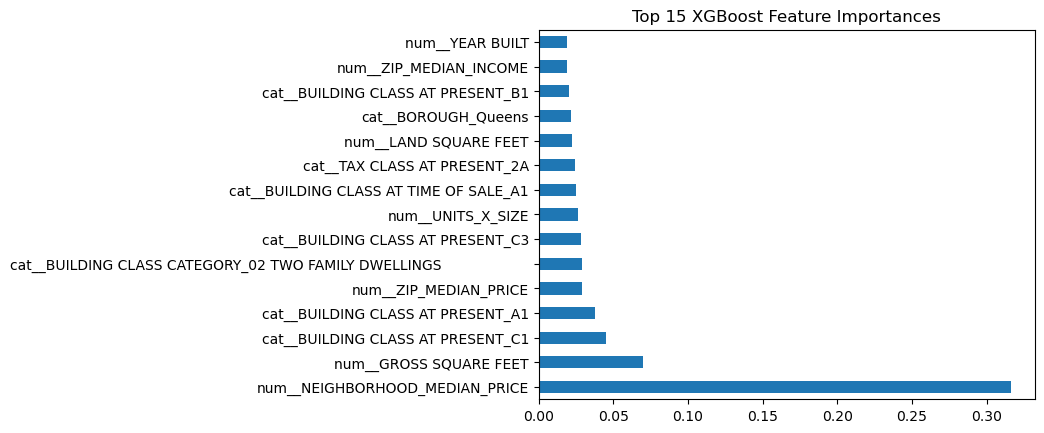

In [ ]:
importances = xgb_model.named_steps['regressor'].feature_importances_
features = xgb_model.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 XGBoost Feature Importances")
plt.show()

A bit strang that num_neighborhood_median_price is so high

In [66]:
#tune the model
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(
    xgb_model,  
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__learning_rate=0.01, reg

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ZIP_MEDIAN_PRICE',
                                                                          'NEIGHBORHOOD_MEDIAN_PRICE',
                                                                          'RESIDENTIAL '
                                                                          'UNITS',
                                                                          'TOTAL '
                                                                          'UNITS',
                                                                          'LAND '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'GROSS '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'YEAR '
                                                                          'BUILT',
                                                                          'TAX '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'TIME '
                                                                          'OF '
                                                                          'SALE',
                                                                          'BUILDING_AGE',
                                                                          'SIZE_X_AGE',
                                                                          'UNITS_X_SIZE',
                                                                          'WALK_SCORE_ZIP',...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 6, 10],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)

print("Tuned XGBoost Results:")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R-squared: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")


Tuned XGBoost Results:
RMSE: 186,367
MAE: 128,922
R²: 0.592
% within ±10%: 34.33%


Tuning shows no improvement

In [68]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME,SIZE_X_AGE,UNITS_X_SIZE,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,117,88.819523,"38 BARROW STREET, 1, NY 10014",100,167254.0,412308.0,17620.0,313000.0,313000.0,0
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,107,471.875000,"307 WEST 136 STREET, 1, NY 10030",97,42738.0,342400.0,3200.0,1300000.0,1272013.0,0
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,118,297.619048,"227 EDGECOMBE AVENUE, 1, NY 10030",97,42738.0,396480.0,3360.0,1300000.0,1272013.0,0
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,118,478.395062,"2040 MADISON AVENUE, 1, NY 10035",99,40556.0,382320.0,6480.0,1300000.0,1493750.0,0
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,118,363.888889,"252 WEST 132 STREET, 1, NY 10027",99,64220.0,424800.0,7200.0,1300000.0,1193000.0,0


In [69]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="nyc-housing-model")

# Example
location = geolocator.geocode("10001, New York, NY")
print(location.latitude, location.longitude)

40.7484675 -73.9941134


Worked with LLM to incorporate zip code level latitude and longitutde. Hopeing to use some sort of distances to give model more to work off of.

In [72]:
unique_zips = df['ZIP CODE'].unique()
zip_to_coords = {}

for z in unique_zips:
    loc = geolocator.geocode(f"{z}, New York, NY")
    if loc:
        zip_to_coords[z] = (loc.latitude, loc.longitude)

In [73]:
df['ZIP_LAT'] = df['ZIP CODE'].map(lambda x: zip_to_coords.get(x, (None, None))[0])
df['ZIP_LON'] = df['ZIP CODE'].map(lambda x: zip_to_coords.get(x, (None, None))[1])


In [74]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,FULL_ADDRESS,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME,SIZE_X_AGE,UNITS_X_SIZE,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY,ZIP_LAT,ZIP_LON
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,"38 BARROW STREET, 1, NY 10014",100,167254.0,412308.0,17620.0,313000.0,313000.0,0,40.733938,-74.004932
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,"307 WEST 136 STREET, 1, NY 10030",97,42738.0,342400.0,3200.0,1300000.0,1272013.0,0,40.818100,-73.943115
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,"227 EDGECOMBE AVENUE, 1, NY 10030",97,42738.0,396480.0,3360.0,1300000.0,1272013.0,0,40.818100,-73.943115
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,"2040 MADISON AVENUE, 1, NY 10035",99,40556.0,382320.0,6480.0,1300000.0,1493750.0,0,40.794488,-73.941639
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,"252 WEST 132 STREET, 1, NY 10027",99,64220.0,424800.0,7200.0,1300000.0,1193000.0,0,40.810465,-73.950531


In [75]:
# Load the updated dataset
sub_df = pd.read_csv('MTA_Subway_Entrances_and_Exits__2024.csv')


Now that I have zip level lat and long... looking at subways. Public transit could drive prices up.

In [76]:
sub_df.columns

Index(['Division', 'Line', 'Borough', 'Stop Name', 'Complex ID',
       'Constituent Station Name', 'Station ID', 'GTFS Stop ID',
       'Daytime Routes', 'Entrance Type', 'Entry Allowed', 'Exit Allowed',
       'Entrance Latitude', 'Entrance Longitude', 'entrance_georeference'],
      dtype='object')

In [77]:
# Extract lat/lon and rename
subway_coords = sub_df[['Entrance Latitude', 'Entrance Longitude']].dropna()
subway_coords.columns = ['SUB_LAT', 'SUB_LON']

In [78]:
#copied directly from chatgpt to compute subway distance
from math import radians, sin, cos, sqrt, atan2

def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# For each property row, compute distance to every subway point and take min
def min_subway_distance(row, subway_coords):
    return subway_coords.apply(
        lambda sub: haversine_vec(row['ZIP_LAT'], row['ZIP_LON'], sub['SUB_LAT'], sub['SUB_LON']),
        axis=1
    ).min()

# Apply to your whole dataset
df['DIST_TO_SUBWAY_KM'] = df.apply(
    lambda row: min_subway_distance(row, subway_coords),
    axis=1
)

In [79]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME,SIZE_X_AGE,UNITS_X_SIZE,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY,ZIP_LAT,ZIP_LON,DIST_TO_SUBWAY_KM
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,100,167254.0,412308.0,17620.0,313000.0,313000.0,0,40.733938,-74.004932,0.154113
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,97,42738.0,342400.0,3200.0,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,97,42738.0,396480.0,3360.0,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,99,40556.0,382320.0,6480.0,1300000.0,1493750.0,0,40.794488,-73.941639,0.222430
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,99,64220.0,424800.0,7200.0,1300000.0,1193000.0,0,40.810465,-73.950531,0.158694


In [80]:
df['DIST_TO_SUBWAY_KM'].corr(df['SALE PRICE'])
#see correlation between newly created subway distance

-0.13184771100414885

Small correlation with subway distance and sales price.

In [81]:
#new features list
categorical_features_two = [
    'BOROUGH',
    'BUILDING CLASS CATEGORY',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS AT PRESENT',
    'BUILDING CLASS AT TIME OF SALE',
    'IS_LUXURY'
]

numerical_features_two = [
    'ZIP_MEDIAN_PRICE',
    'NEIGHBORHOOD_MEDIAN_PRICE',
    'RESIDENTIAL UNITS',
    'TOTAL UNITS',
    'LAND SQUARE FEET',
    'GROSS SQUARE FEET',
    'YEAR BUILT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING_AGE',
    'SIZE_X_AGE',
    'UNITS_X_SIZE',
    'WALK_SCORE_ZIP',
    'ZIP_MEDIAN_INCOME',
    'DIST_TO_SUBWAY_KM'
]


In [ ]:
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [83]:
#new Preprocessor
preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)
])

# Pipeline (base — reused for GridSearchCV)
xgb_model_two = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

In [ ]:
grid_search = GridSearchCV(
    xgb_model_two,
    param_grid=param_grid,  # reuse original param grid
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.6s
[CV] END regressor__learning_rate=0.01, reg

In [ ]:
y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)

print("Tuned XGBoost With Subway Distance:")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R-squared: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

Tuned XGBoost With Subway Distance:
RMSE: 186,322
MAE: 128,963
R²: 0.593
% within ±10%: 33.92%


No real improvement with subway information

In [86]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'BUILDING_AGE', 'PRICE_PER_SQFT',
       'FULL_ADDRESS', 'WALK_SCORE_ZIP', 'ZIP_MEDIAN_INCOME', 'SIZE_X_AGE',
       'UNITS_X_SIZE', 'NEIGHBORHOOD_MEDIAN_PRICE', 'ZIP_MEDIAN_PRICE',
       'IS_LUXURY', 'ZIP_LAT', 'ZIP_LON', 'DIST_TO_SUBWAY_KM'],
      dtype='object')

In [87]:
df_pluto = pd.read_csv('pluto_25v1_1.csv')

Talked to gpt about how to improve modeling. Suggested I incorporate PLUTO dataset from NYC.gov. This will allow me to use real latitude and longitude as opposed to ZIP level. More exact coordinates might help the model.

In [88]:
df_pluto.head()

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,SI,6020,28,503.0,5017013.0,5.017013e+10,170.10,2000.0,31.0,51.0,...,NaN,NaN,1,NaN,NaN,25v1.1,NaN,40.557352,-74.196460,NaN
1,SI,1183,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,NaN,NaN,25v1.1,t,NaN,NaN,NaN
2,QN,15100,575,414.0,4107202.0,4.107202e+10,1072.02,2.0,NaN,32.0,...,NaN,NaN,4,1.0,1.0,25v1.1,NaN,40.606646,-73.815428,NaN
3,MN,1371,30,106.0,1010601.0,1.010601e+10,106.01,1.0,NaN,5.0,...,NaN,NaN,4,1.0,1.0,25v1.1,t,40.755686,-73.960747,NaN
4,SI,7722,200,503.0,5024402.0,5.024402e+10,244.02,1.0,NaN,51.0,...,NaN,NaN,5,1.0,1.0,25v1.1,NaN,40.496841,-74.234707,NaN


In [89]:
df_pluto.shape

(858629, 92)

In [90]:
df_pluto.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

In [91]:
df_pluto = pd.read_csv("pluto_25v1_1.csv", dtype={'BBL': str}) #convert bbl to string

In [92]:
df_pluto.columns = df_pluto.columns.str.upper()
print(df_pluto[['BBL', 'LATITUDE', 'LONGITUDE']].head())

            BBL   LATITUDE  LONGITUDE
0  5.060200e+09  40.557352 -74.196460
1  5.011830e+09        NaN        NaN
2  4.151001e+09  40.606646 -73.815428
3  1.013710e+09  40.755686 -73.960747
4  5.077220e+09  40.496841 -74.234707


In [93]:
df_pluto['BBL'] = df_pluto['BBL'].fillna(0).astype('int64').astype(str).str.zfill(10) #was having issues getting BBL converted to string properly

In [94]:
print(df_pluto['BBL'].head())

0    5060200028
1    5011830073
2    4151000575
3    1013710030
4    5077220200
Name: BBL, dtype: object


In [ ]:
#for sake of merging pluto. Get real coordinates instead of zip coordinates using bbl. (borough block lot). need to generate BBL column. Generated by LLM

borough_map = {
    'Manhattan': '1',
    'Bronx': '2',
    'Brooklyn': '3',
    'Queens': '4',
    'Staten Island': '5'
}

df['BBL_BOROUGH'] = df['BOROUGH'].map(borough_map)
df['BBL'] = (
    df['BBL_BOROUGH'].astype(str).str.zfill(1) +
    df['BLOCK'].astype(str).str.zfill(5) +
    df['LOT'].astype(str).str.zfill(4)
)

In [ ]:
df = df.merge(df_pluto[['BBL', 'LATITUDE', 'LONGITUDE']], on='BBL', how='left')

In [97]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY,ZIP_LAT,ZIP_LON,DIST_TO_SUBWAY_KM,BBL_BOROUGH,BBL,LATITUDE,LONGITUDE
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,313000.0,313000.0,0,40.733938,-74.004932,0.154113,1,1005880032,40.732308,-74.004261
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145,1,1019600041,40.817599,-73.946476
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145,1,1020510062,40.823310,-73.944361
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,1300000.0,1493750.0,0,40.794488,-73.941639,0.222430,1,1017540116,40.808592,-73.938876
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,1300000.0,1193000.0,0,40.810465,-73.950531,0.158694,1,1019370052,40.813913,-73.946941


In [98]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'BUILDING_AGE', 'PRICE_PER_SQFT',
       'FULL_ADDRESS', 'WALK_SCORE_ZIP', 'ZIP_MEDIAN_INCOME', 'SIZE_X_AGE',
       'UNITS_X_SIZE', 'NEIGHBORHOOD_MEDIAN_PRICE', 'ZIP_MEDIAN_PRICE',
       'IS_LUXURY', 'ZIP_LAT', 'ZIP_LON', 'DIST_TO_SUBWAY_KM', 'BBL_BOROUGH',
       'BBL', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [ ]:
#for clarity

df.rename(columns={'LATITUDE': 'REAL_LAT','LONGITUDE': 'REAL_LON'}, inplace=True)

In [100]:
#same code as before, but now using real alt and long

# Haversine function (unchanged)
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Updated version to use REAL_LAT and REAL_LON
def min_subway_distance(row, subway_coords):
    return subway_coords.apply(
        lambda sub: haversine_vec(row['REAL_LAT'], row['REAL_LON'], sub['SUB_LAT'], sub['SUB_LON']),
        axis=1
    ).min()

# Compute for all rows — this will still be slow on large datasets
df['DIST_TO_SUBWAY_KM'] = df.apply(
    lambda row: min_subway_distance(row, subway_coords),
    axis=1
)


In [ ]:
# df.to_csv("nyc_housing_with_subway_distance.csv", index=False)

In [102]:
MIDTOWN_LAT = 40.7580
MIDTOWN_LON = -73.9855
#times square... going to compute distance to times square. seems like could be good indicator of value 
#per google

In [103]:
df['DIST_TO_MIDTOWN_KM'] = df.apply(
    lambda row: haversine_vec(row['REAL_LAT'], row['REAL_LON'], MIDTOWN_LAT, MIDTOWN_LON),
    axis=1
)

In [104]:
print(df['DIST_TO_MIDTOWN_KM'].describe())
print("Correlation with SALE PRICE:", df['DIST_TO_MIDTOWN_KM'].corr(df['SALE PRICE']))
#yay real correlation!

count    21642.000000
mean        17.016555
std          5.381771
min          3.264921
25%         13.317586
50%         16.632244
75%         20.140097
max         36.102351
Name: DIST_TO_MIDTOWN_KM, dtype: float64
Correlation with SALE PRICE: -0.29790598146881786


I'm excited about having a decent level of correlation. The futher you get from Times Square, the lower the value of the property is.

In [105]:
numerical_features_two.append('DIST_TO_MIDTOWN_KM')
numerical_features_two.append('DIST_TO_SUBWAY_KM')


In [ ]:
numerical_features_two = list(set(numerical_features_two))
#drop duplicates. Was getting errors

In [ ]:
# Updated preprocessor
preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)
])

# pipeline
xgb_model_two = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

In [108]:
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#grid search for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(
    xgb_model_two,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   2.1s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   2.2s
[CV] END regressor__learning_rate=0.01, reg

In [ ]:
y_pred = best_xgb.predict(X_test)

print("Tuned XGBoost with DIST_TO_MIDTOWN_KM:")
print(f"R-squared: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")
print(f"% within ±10%: {np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10):.2%}")

Tuned XGBoost with DIST_TO_MIDTOWN_KM:
R²: 0.594
MAE: 128,787
RMSE: 186,016
% within ±10%: 34.47%


Still not cracking 60 r-squared. Thinking to myself... what is missing here? Why am I seemingly hitting a wall? I have created multiple features. Looked at subway location/location to times square, median income, ZIP and property specific coordinates. I tested splitting by borough with no luck (removed for speed of the notebook).

One key piece of data that I think might be limiting my model is lack of knowledge about property condition. A distressed property would obviously have much lower value than a new/refurbished one. Going to try to come up with some sort of proxy for property condition? Maybe age?

In [111]:
df['IS_NEW'] = (df['BUILDING_AGE'] <= 17).astype(int)

#anything later than 2000 is going to be "new". Presumably new would imply decent to good condition. 

In [112]:
corr = df['IS_NEW'].corr(df['SALE PRICE'])
corr

#this did not work. maybe I break it down in more detail

-0.0020531052759966816

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21758 entries, 0 to 21757
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         21758 non-null  object 
 1   NEIGHBORHOOD                    21758 non-null  object 
 2   BUILDING CLASS CATEGORY         21758 non-null  object 
 3   TAX CLASS AT PRESENT            21758 non-null  object 
 4   BLOCK                           21758 non-null  int64  
 5   LOT                             21758 non-null  int64  
 6   BUILDING CLASS AT PRESENT       21758 non-null  object 
 7   ADDRESS                         21758 non-null  object 
 8   APARTMENT NUMBER                21758 non-null  object 
 9   ZIP CODE                        21758 non-null  int64  
 10  RESIDENTIAL UNITS               21758 non-null  int64  
 11  TOTAL UNITS                     21758 non-null  int64  
 12  LAND SQUARE FEET                

In [114]:
def categorize_age(age):
    if age <= 15:
        return 'New (<15)'
    elif age <= 50:
        return 'Modern (16–50)'
    elif age <= 80:
        return 'Mid-Century (51–80)'
    elif age <= 120:
        return 'Pre-War (81–120)'
    else:
        return 'Historic (120+)'

df['AGE_CATEGORY'] = df['BUILDING_AGE'].apply(categorize_age)

In [115]:
categorical_features_two.append('AGE_CATEGORY')

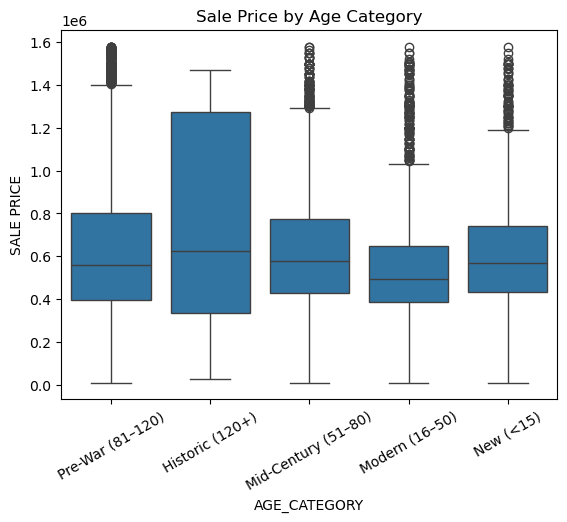

In [116]:
sns.boxplot(data=df, x='AGE_CATEGORY', y='SALE PRICE')
plt.xticks(rotation=30)
plt.title("Sale Price by Age Category")
plt.show()

In [117]:
#try interaction terms
df['AGE_CLASS_INTERACTION'] = df['AGE_CATEGORY'] + '_' + df['BUILDING CLASS AT TIME OF SALE']

In [118]:
categorical_features_two.append('AGE_CLASS_INTERACTION')

In [119]:
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
# Preprocessor
preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)
])

# XGBoost pipeline
xgb_model_three = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

In [121]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(
    xgb_model_three,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.4s
[CV] END regressor__learning_rate=0.01, reg

In [ ]:
y_pred = best_xgb.predict(X_test)

print("Tuned XGBoost with AGE_CLASS_INTERACTION:")
print(f"R-squared: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")
print(f"% within ±10%: {np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10):.2%}")

Tuned XGBoost with AGE_CLASS_INTERACTION:
R²: 0.589
MAE: 129,132
RMSE: 187,221
% within ±10%: 34.81%


Model performance decreased with addition of classified age

In [123]:
categorical_features_two.remove('AGE_CLASS_INTERACTION') #this made the model slightly worse!

Going to try MLREGRESSOR

In [124]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)])

In [125]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        learning_rate='adaptive', #will continue to cut learning rate if necessary
        max_iter=500,
        early_stopping=True,
        random_state=42))])

In [126]:
X_train.isna().sum().sort_values(ascending=False).head(10) #initial attempt showed 91 NaNs in Dist to Subway and Dist to Midtown

DIST_TO_MIDTOWN_KM           91
DIST_TO_SUBWAY_KM            91
BOROUGH                       0
RESIDENTIAL UNITS             0
TAX CLASS AT TIME OF SALE     0
BUILDING_AGE                  0
SIZE_X_AGE                    0
LAND SQUARE FEET              0
UNITS_X_SIZE                  0
GROSS SQUARE FEET             0
dtype: int64

In [127]:
X = df[categorical_features_two + numerical_features_two].copy()
y = df['SALE PRICE']

# Drop rows where any modeling feature is NaN... asked gpt for cleanest way to drop without messing up data
model_data = pd.concat([X, y], axis=1).dropna()
X = model_data[categorical_features_two + numerical_features_two]
y = model_data['SALE PRICE']

In [128]:
#need to redo this to avoid error of Nans
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
#Fit the model
mlp_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = mlp_pipeline.predict(X_test)

print("MLPRegressor Results:")
print(f"R-squared: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")
print(f"% within ±10%: {np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10):.2%}")

#results unfortunately worse. 

MLPRegressor Results:
R²: 0.549
MAE: 137,142
RMSE: 198,372
% within ±10%: 33.52%


MLP Regressor model decreased performance. Will not use going forward.

In [ ]:
crime_df= pd.read_csv('NYPD_Complaint_Data_Historic_20250613.csv')
#try crime data

In [131]:
crime_df.shape

(828330, 35)

In [132]:
crime_df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,298672393,12/31/2014,03:20:00,12/31/2014,03:21:00,25.0,12/31/2024,341,PETIT LARCENY,321.0,...,U,NaN,40.804376,-73.937420,"(40.804375769710255, -73.93742023722204)",PATROL BORO MAN NORTH,(null),UNKNOWN,UNKNOWN,E
1,298621600,05/03/2016,13:00:00,08/23/2024,14:00:00,62.0,12/27/2024,109,GRAND LARCENY,422.0,...,U,NaN,40.604280,-73.980944,"(40.60428, -73.980944)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,F
2,298182583,01/01/2016,07:00:00,NaN,(null),45.0,12/18/2024,233,SEX CRIMES,170.0,...,U,NaN,40.830722,-73.827126,"(40.8307223277672, -73.8271260588639)",PATROL BORO BRONX,(null),<18,WHITE HISPANIC,F
3,298187399,03/18/2015,12:00:00,09/25/2015,12:00:00,52.0,12/18/2024,104,RAPE,157.0,...,M,NaN,40.869470,-73.879861,"(40.8694704770483, -73.8798608037303)",PATROL BORO BRONX,(null),18-24,BLACK,F
4,298058521,12/15/2016,00:01:00,12/15/2016,04:00:00,75.0,12/16/2024,107,BURGLARY,223.0,...,U,NaN,40.666657,-73.892069,"(40.666657, -73.892069)",PATROL BORO BKLYN NORTH,(null),UNKNOWN,UNKNOWN,D


In [133]:
crime_df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

In [134]:
crime_df.isnull().sum()

CMPLNT_NUM                0
CMPLNT_FR_DT              0
CMPLNT_FR_TM              0
CMPLNT_TO_DT         143624
CMPLNT_TO_TM              0
ADDR_PCT_CD               1
RPT_DT                    0
KY_CD                     0
OFNS_DESC                 0
PD_CD                   678
PD_DESC                   0
CRM_ATPT_CPTD_CD          0
LAW_CAT_CD                0
BORO_NM                   0
LOC_OF_OCCUR_DESC         0
PREM_TYP_DESC             0
JURIS_DESC                0
JURISDICTION_CODE         0
PARKS_NM                  0
HADEVELOPT                0
HOUSING_PSA             133
X_COORD_CD                1
Y_COORD_CD                1
SUSP_AGE_GROUP            0
SUSP_RACE                 0
SUSP_SEX                  0
TRANSIT_DISTRICT     806806
Latitude                  1
Longitude                 1
Lat_Lon                   1
PATROL_BORO               0
STATION_NAME              0
VIC_AGE_GROUP             0
VIC_RACE                  0
VIC_SEX                   0
dtype: int64

In [135]:
crime_df = crime_df.dropna(subset=['Latitude', 'Longitude']) #drop the one null. going to merge on lat/long


In [136]:
#asked gpt how to merge in crimes within a short distance from properties... I have lat and long. I asked for a detailed explanation of each line of code so I could understand what is being implemented

#Import libraries
from sklearn.neighbors import BallTree

# Step 1: Drop missing lat/lon from both DataFrames
crime_df_clean = crime_df.dropna(subset=['Latitude', 'Longitude'])
property_df_clean = df.dropna(subset=['REAL_LAT', 'REAL_LON'])

# Step 2: Convert degrees to radians (required for haversine distance)
crime_coords = np.radians(crime_df_clean[['Latitude', 'Longitude']].values)
property_coords = np.radians(property_df_clean[['REAL_LAT', 'REAL_LON']].values)

# Step 3: Build a BallTree from the crime coordinates using haversine metric
tree = BallTree(crime_coords, metric='haversine')

# Step 4: Query for crimes within 0.5 km (converted to radians)
radius_km = 0.5
radius_rad = radius_km / 6371.0  # 6371 km = Earth's radius
indices_within_radius = tree.query_radius(property_coords, r=radius_rad)

# Step 5: Count crimes for each property
crime_counts = [len(neighbors) for neighbors in indices_within_radius]

# Step 6: Assign crime counts to property DataFrame
property_df_clean['CRIMES_WITHIN_0_5KM'] = crime_counts

# Step 7: Merge crime count back to full original DataFrame by index
df['CRIMES_WITHIN_0_5KM'] = property_df_clean['CRIMES_WITHIN_0_5KM']
df['CRIMES_WITHIN_0_5KM'] = df['CRIMES_WITHIN_0_5KM'].fillna(0)  # fill missing with 0


In [ ]:
df['CRIMES_WITHIN_0_5KM'].corr(df['SALE PRICE'])
#no good 

0.011319394718291525

In [ ]:
#Going to try various interaction terms with crime metric
df['CRIME_X_INCOME'] = df['CRIMES_WITHIN_0_5KM'] * df['ZIP_MEDIAN_INCOME']

df['CRIME_X_INCOME'].corr(df['SALE PRICE'])

0.058749042792146704

In [139]:
df['CRIME_X_MIDTOWN'] = df['CRIMES_WITHIN_0_5KM'] * df['DIST_TO_MIDTOWN_KM']

df['CRIME_X_MIDTOWN'].corr(df['SALE PRICE'])

-0.10778444987690391

In [ ]:
df['CRIME_X_SIZE'] = df['CRIMES_WITHIN_0_5KM'] * df['GROSS SQUARE FEET']

df['CRIME_X_SIZE'].corr(df['SALE PRICE'])

#large buildings in high crime areas undervalued?

0.12184980731640252

Correlationsn of newly created interaction terms are little to moderate.

In [ ]:
#one more attempt with park data. Trying something other than distance metrics. Seems to not be helping. 
parks_df = pd.read_csv("Parks_Properties_20250616.csv")

parks_df.columns

Index(['ACQUISITIONDATE', 'ACRES', 'ADDRESS', 'BOROUGH', 'CLASS',
       'COMMUNITYBOARD', 'COUNCILDISTRICT', 'DEPARTMENT', 'EAPPLY', 'GISOBJID',
       'GISPROPNUM', 'GlobalID', 'JURISDICTION', 'LOCATION', 'MAPPED',
       'NAME311', 'NYS_ASSEMBLY', 'NYS_SENATE', 'OBJECTID', 'OMPPROPID',
       'PARENTID', 'PERMIT', 'PERMITDISTRICT', 'PERMITPARENT', 'PIP_RATABLE',
       'PRECINCT', 'RETIRED', 'SIGNNAME', 'SUBCATEGORY', 'TYPECATEGORY',
       'US_CONGRESS', 'WATERFRONT', 'ZIPCODE', 'multipolygon'],
      dtype='object')

In [ ]:
df.dtypes #to merge on zip...

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
TOTAL UNITS                         int64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
SALE DATE                          object
BUILDING_AGE                        int64
PRICE_PER_SQFT                    float64
FULL_ADDRESS                       object
WALK_SCORE_ZIP                      int64
ZIP_MEDIAN_INCOME                 

In [ ]:
df['ZIP CODE'] = df['ZIP CODE'].astype(str)

#Group total park acres by ZIP code
parks_by_zip = parks_df.groupby('ZIPCODE')['ACRES'].sum().reset_index()
parks_by_zip.columns = ['ZIP CODE', 'TOTAL_PARK_ACRES'] 

parks_by_zip['ZIP CODE'] = parks_by_zip['ZIP CODE'].astype(str) #convert to string for merge

#Merge into housing DataFrame
df = df.merge(parks_by_zip, on='ZIP CODE', how='left')

df['TOTAL_PARK_ACRES'] = df['TOTAL_PARK_ACRES'].fillna(0)


In [ ]:
df['TOTAL_PARK_ACRES'].corr(df['SALE PRICE'])

#weird? negative correlation? Maybe larger parks are in less expensive areas

-0.13117536690917436

In [160]:
df['PARK_X_INCOME'] = df['TOTAL_PARK_ACRES'] * df['ZIP_MEDIAN_INCOME']

df['PARK_X_INCOME'].corr(df['SALE PRICE'])

-0.11767751706796103

In [161]:
numerical_features_two.append('CRIME_X_INCOME')
numerical_features_two.append('CRIME_X_MIDTOWN')
numerical_features_two.append('CRIME_X_SIZE')
numerical_features_two.append('PARK_X_INCOME')


In [ ]:
# Define X and y again
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #being forced to re-split everytime I add something to the list

In [ ]:
# Preprocessor... again
preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)])

# XGBoost pipeline
xgb_model_two = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Train and evaluate
xgb_model_two.fit(X_train, y_train)
y_pred = xgb_model_two.predict(X_test)

print("Last attempt with Interaction Terms:")
print(f"R-squared: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")
print(f"% within ±10%: {np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10):.2%}")


Last attempt with Interaction Terms:
R-squared: 0.584
MAE: 129,977
RMSE: 188,370
% within ±10%: 35.36%


R-squared still not highest, but within 10% has reached its high

In [ ]:
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']

cv_scores = cross_val_score(
    xgb_model_two,     
    X, y,            
    scoring='r2',    
    cv=5
)

print("Cross-validated R-squared scores:", cv_scores)
print("Mean R-squared:", np.mean(cv_scores))

#results are worse?

Cross-validated R² scores: [0.5397452  0.42410267 0.52505166 0.51008305 0.47163219]
Mean R²: 0.4941229528920369


While the tuned XGBoost model achieved an r-squared of 0.594 on the test set, cross-validated performance was lower (mean R-squared: 0.49). This suggests the model performs well on typical sales but may struggle with unusual sales.

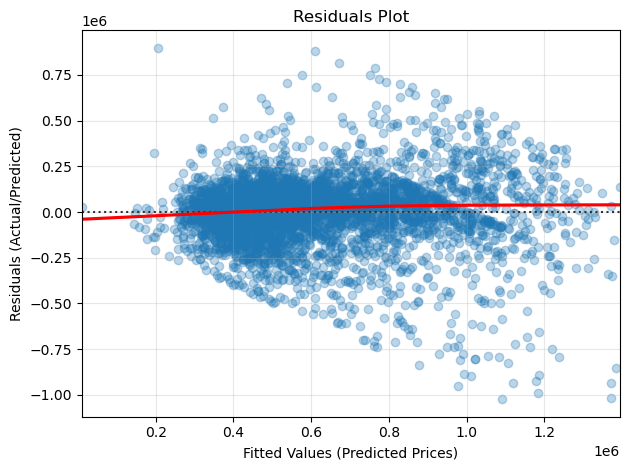

In [180]:
#residual plot
residuals = y_test - y_pred
sns.residplot(x=y_pred,y=residuals,lowess=True, line_kws={"color": "red"}, scatter_kws={"alpha": 0.3}
)
plt.xlabel("Fitted Values (Predicted Prices)")
plt.ylabel("Residuals (Actual/Predicted)")
plt.title("Residuals Plot")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Suggests model is decent at mid level prices but sturggles with low or high values.

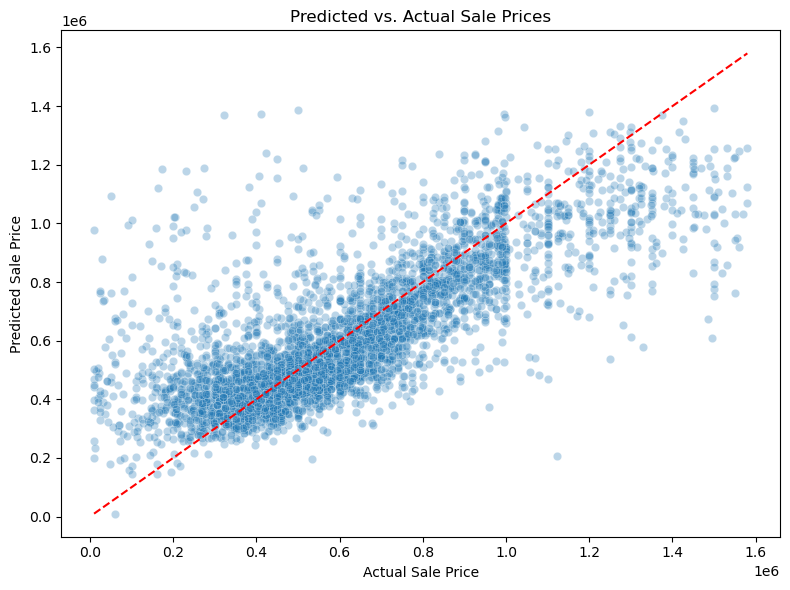

In [170]:
#asked gpt for code to plot predicted vs acutal sales price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Predicted vs. Actual Sale Prices")
plt.tight_layout()
plt.show()

Again, see the model struggling with higher or lower values.

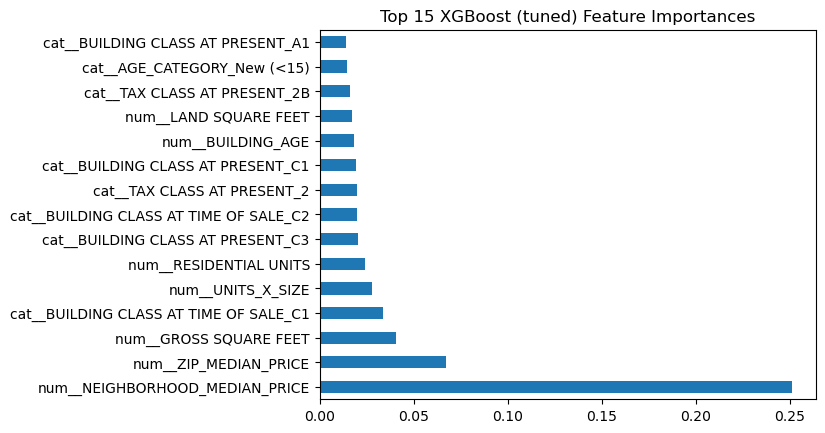

In [177]:
importances = xgb_model_two.named_steps['regressor'].feature_importances_
features = xgb_model_two.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 XGBoost (tuned) Feature Importances")
plt.show()

## Conclusion

As outlined above, the goal of the project was to build a predictive model that had:
1) Strong r-squared, MAE, RMSE
2) 80% of predictions within 10% of the predicted value

The idea was to create a model that would help stakeholders (a real estate firm, agents, investors, sellers) improve their listing prices, reduce time on the market, and maximize seller ROI. I tested several models including linear regression, random forest (with GridSearch), XGBoost (with GridSearch), and MLPRegressor. All of the models that were tested (with extensive feature engineering and use of outside data) did not yield strong results with the best (tuned XGBoost) having an r-squared value of 0.594, MAE of ~$129,000, RMSE ~$186,000, and a within 10% predictive rate of 34.47%. I also ran a cross-validation and got a cross validated R-squared value of 0.49.

I believe that  the reason for the model's lack of strong performance is mainly a lack of interior condition/renovation data. Additionally, I believe that it is the main cause in limiting model gain from sources such as WalkScore, crime, and park data. I also believe that numebrs of bed/bath per unit and amenity information would help.

As such, I have the following business recommendations:
1) It seems to perform best for mid-range values. Do not use this model for cheap or expensive (outlier) properties
2) Invest in more data: Renovation status, amenities, interior features, and post-2017 data would likely drive major gains.
3) Treat this model as a guide, not a replacement for agent expertise. This should not automate pricing.

## Self Reflection

I encountered meaningful limitations in the data that shaped the outcome of this project. When I began, I felt as if I was going to be in a really strong position. It became increasingly clear what critical features were missing: renovation status, interior quality, building amenities and real time market information.

New York City is also a unique housing market, with pricing often being influenced by factors that are difficult to capture with public data. Perhaps this could have been stronger looking in a different area of the country.

Overall, this project has been a good learning experience for me. Ittaught me the importance of feature quality, the limits of public data, and the trade-offs between technical precision and real-world applicability. It was a valuable exercise in end-to-end modeling, storytelling, and stakeholder framing.

Ultimately, this project demonstrated that machine learning can support, but not replace, human pricing expertise in complex markets like NYC. Future improvements will require deeper, property-level data.